In [2]:
import os
import numpy as np
import h5py
import rusyllab
import re
import copy
import matplotlib.pyplot as plt

from tqdm import tqdm

import codecs
from russian_g2p.Accentor import Accentor
from russian_g2p.Grapheme2Phoneme import Grapheme2Phoneme

from functools import reduce

import scipy.stats

## Files and phonemes

In [3]:
def readlines(filepath):
    lines = []
    with codecs.open(filepath, 'r', encoding='utf-8') as file:
        for line in file.readlines():
            line = line.strip()
            if len(line) > 0:
                lines.append(line)
    return lines

def make_accent(words):
    return list(map(lambda x: x[:2] + '+' + x[2:], words))

def make_transcript(words):
    transcript2word = {}
    accents = make_accent(words)
    transcriptor = Grapheme2Phoneme()
    transcript = []
    for i, accent in enumerate(accents):
        script = transcriptor.word_to_phonemes(accent)
        transcript.append(script)
        transcript2word[''.join(script)] = i
    return transcript, transcript2word

def make_transcript_simple(transcript, words=None):
    transcript2word = {}
    transcript_new = []
    for i, script in enumerate(transcript):
        script_new = []
        for phoneme in script:
            if ('0' in phoneme) and (phoneme[0] != 'J'):
                script_new.append(phoneme[:-1])
            else:
                script_new.append(phoneme)
        if words is not None:
            transcript2word[''.join(script_new)] = i
        transcript_new.append(script_new)
    return transcript_new, transcript2word

def count_total(ls):
    ls = reduce(lambda acc, x: acc + x, ls)
    counts = {}
    for phoneme in ls:
        if phoneme in counts:
            counts[phoneme] += 1
        else:
            counts[phoneme] = 1
    return counts

def phoneme_filter(transcript, phoneme_set):
    transcript_new = []
    for script in transcript:
        count = 0
        for phoneme in script:
            if phoneme in phoneme_set:
                count += 1
        if count == len(script):
            transcript_new.append(copy.copy(script))
    return transcript_new

def phoneme_filter_hard(transcript, phoneme_set_simple, phoneme_set):
    transcript_simple, _ = make_transcript_simple(transcript) 
    transcript_new = []
    for i, script in enumerate(transcript_simple):
        count = 0
        for phoneme in script:
            if phoneme in phoneme_set_simple:
                count += 1
        if count == len(script):
            transcript_new.append(copy.copy(transcript[i]))
    return transcript_new

In [5]:
dirpath = r'words/CVCVC/'
nounfile = 'nouns4hand1.txt'
verbfile = 'verbs1hand2.txt'
adjfile = 'adj1hand1.txt'

In [6]:
phonems = {}
phonems['vowels'] = ['A', 'U', 'E', 'O', 'I', 'Y']
phonems['vowels_short'] = ['A', 'U', 'E', 'O', 'I']
phonems['vowels_accent'] = ['A0', 'U0', 'E0', 'O0', 'I0', 'Y0']
phonems['consonants_sonorous'] = ['M', 'N', 'L', 'R']
phonems['consonants_sonorous_soft'] = ['M0', 'N0', 'L0', 'R0']
phonems['consonants_voiced'] = ['B', 'V', 'G', 'D', 'Z']
phonems['consonants_voiced_soft'] = ['B0', 'V0', 'G0', 'D0', 'Z0']
phonems['consonants_unvoiced'] = ['P', 'F', 'K', 'T', 'S']
phonems['consonants_unvoiced_soft'] = ['P0', 'F0', 'K0', 'T0', 'S0']

phonems_V_full = phonems['vowels'] + phonems['vowels_accent']
phonems_C_sound = phonems['consonants_sonorous'] + phonems['consonants_voiced']
phonems_C_hard = phonems['consonants_sonorous'] + phonems['consonants_voiced'] + phonems['consonants_unvoiced']
phonems_C_soft = phonems['consonants_sonorous_soft'] + phonems['consonants_voiced_soft'] + phonems['consonants_unvoiced_soft']

phonems['consonants_J0'] = ['J0']
phonems['consonants_voiced_add'] = ['ZH']
phonems['consonants_unvoiced_add1'] = ['SH']
phonems['consonants_unvoiced_add2'] = ['KH']
phonems['consonants_unvoiced_soft_add'] = ['SH0']  

In [19]:
phonemes15 = phonems['vowels'] + phonems['consonants_sonorous'] + phonems['consonants_voiced']
phonemes16 = phonems['vowels'] + phonems['consonants_sonorous'] + phonems['consonants_voiced'] + phonems['consonants_voiced_add']
phonemes17 = phonems['vowels'] + phonems['consonants_sonorous'] + phonems['consonants_voiced'] + phonems['consonants_voiced_add'] + phonems['consonants_J0']

phonemes21 = phonems['vowels'] + phonems_C_hard + phonems['consonants_J0']

phonemes35 = phonems['vowels'] + phonems_C_hard + phonems_C_soft + phonems['consonants_J0']
phonemes41 = phonems_V_full + phonems_C_hard + phonems_C_soft + phonems['consonants_J0']

## make Vocabulary

In [20]:
class Word:
    def __init__(self, word, index, transcript, transcript_simple):
        self.word = word
        self.index = index
        self.transcript = transcript
        self.transcript_simple = transcript_simple
    
    def __str__(self):
        return  str(self.index) + self.word + ' ' + ''.join(self.transcript) + ' ' + ''.join(self.transcript_simple)
    def __repr__(self):
        return self.word
    

class Vocabulary:
    def __init__(self, noun, verb, adj):
        words = noun, verb, adj
        self.words = [[],[],[]]
        for i, wordls in enumerate(words):
            transcript, _ = make_transcript(wordls)
            transcript_simple, _ = make_transcript_simple(transcript)
            for j in range(len(wordls)):
                word = Word(wordls[j], j, transcript[j], transcript_simple[j])
                self.words[i].append(word)
        
    def phoneme_filter_simple(self, phonemes):
        words = [[],[],[]]
        for i, wordls in enumerate(self.words):
            for word in wordls:
                counter = 0
                for phoneme in word.transcript_simple:
                    if phoneme in phonemes:
                        counter += 1
                if counter == len(word.transcript_simple):
                    words[i].append(word)
        self.words = words
        print(len(self.words[0]), len(self.words[1]), len(self.words[2]))

In [21]:
noun = readlines(dirpath + nounfile)
verb = readlines(dirpath + verbfile)
adj = readlines(dirpath + adjfile)

vocabulary = Vocabulary(noun, verb, adj)
vocabulary.phoneme_filter_simple(phonems21j)

89 35 45


## Get word set from vocabulary

In [22]:
class WordSet():
    def __init__(self, vocabulary, nwords, phonemes, phonemes2, seed=0):
        self.vocabulary = vocabulary
        self.nwords = nwords
        self.phonemes = phonemes
        self.phonemes2 = phonemes2
        self.phonemes2index, self.phonemes2index2 = {}, {}
        for i, phoneme in enumerate(self.phonemes):
            self.phonemes2index[phoneme] = i
        for i, phoneme in enumerate(self.phonemes2):
            self.phonemes2index2[phoneme] = i
        self.entropy_total = []
        self.bestwordset_entropy = []

        self.acc = []
        self.wordset = []
        self.bestwordset = None
        np.random.seed(seed)
        self._random_start()

    def _random_start(self):
        for j, (nword, words) in enumerate(zip(self.nwords, self.vocabulary.words)):
            bad_choice_count = 0
            bad_choice_flag = True
            while bad_choice_flag and (bad_choice_count < 100):
                bad_choice_flag = False
                choice = np.random.choice(np.arange(len(words)), size=nword, replace=False)
                sample = np.zeros(len(words)).astype(int)
                for i in choice:
                    sample[i] = words[i].index
                wordsubset = []
                
                for i in choice:
                    for subword in wordsubset:
                        bad_choice_flag = (j == 1) and words[i].word[:4] == subword.word[:4]
                    wordsubset.append(words[i])
                bad_choice_count += 1
            self.acc.append(sample)
            self.wordset.append(wordsubset)

    def get_entropy(self):
        counts = np.zeros(len(self.phonemes)).astype(int)
        counts2 = np.zeros(len(self.phonemes2)).astype(int)
        counts_subsets = [np.zeros(len(self.phonemes)).astype(int) for _ in range(3)]
        counts2_subsets = [np.zeros(len(self.phonemes2)).astype(int) for _ in range(3)]
        
        for i, subset in enumerate(self.wordset):
            for word in subset:
                for phoneme in word.transcript_simple:
                    counts[self.phonemes2index[phoneme]] += 1
                    counts_subsets[i][self.phonemes2index[phoneme]] += 1
                for phoneme in word.transcript:
                    counts2[self.phonemes2index2[phoneme]] += 1
                    counts2_subsets[i][self.phonemes2index2[phoneme]] += 1
        
        entropy = scipy.stats.entropy(counts)
        entropy2 = scipy.stats.entropy(counts2)
        entropy_subsets = np.mean([scipy.stats.entropy(count) for count in counts_subsets])
        entropy2_subsets = np.mean([scipy.stats.entropy(count2) for count2 in counts2_subsets])
        return entropy, entropy2, entropy_subsets, entropy2_subsets
    
    def get_counts(self, wordset=None):
        if wordset==None:
            wordset=self.wordset
        counts = np.zeros(len(self.phonemes)).astype(int)
        counts2 = np.zeros(len(self.phonemes2)).astype(int)
        for _, subset in enumerate(wordset):
            for word in subset:
                for phoneme in word.transcript_simple:
                    counts[self.phonemes2index[phoneme]] += 1
                for phoneme in word.transcript:
                    counts2[self.phonemes2index2[phoneme]] += 1
        return counts, counts2
        
    def get_entropy_total(self, alpha, beta, gamma, delta):
        entropy, entropy2, entropy_subsets, entropy2_subsets = self.get_entropy()
        return alpha*entropy + beta*entropy2 + gamma*entropy_subsets + delta*entropy2_subsets

    def greedy_entropy_maximization(self, niter=1000, alpha=1, beta=0, gamma=0, delta=0, eps_iter=30, bestwordset_iter=100):
        p = np.asarray(self.nwords) / np.sum(self.nwords)

        entropy_total = self.get_entropy_total(alpha, beta, gamma, delta)
        self.entropy_total.append(entropy_total)
        
        self.bestwordset = copy.deepcopy(self.wordset)
        bestwordset_counter = 0
        eps_counter = 0
        self.bestwordset_entropy.append(entropy_total)
        
        for _ in tqdm(range(niter)):
            choice1 = np.random.choice(np.arange(3), size=1, replace=False, p=p)[0]
            choice2 = np.random.choice(self.nwords[choice1], size=1, replace=False)[0]
            old_word = self.wordset[choice1][choice2]
            old_index = np.where(self.acc[choice1] == old_word.index)[0]
            new_word_possible_index = np.where(self.acc[choice1]==0)[0]
            choice3 = np.random.choice(new_word_possible_index, size=1, replace=False)[0]
            new_word = self.vocabulary.words[choice1][choice3]
            
            bad_word_flag = False
            for word in self.wordset[choice1]:
                if new_word.word[:4] == word.word[:4]:
                    bad_word_flag = True
                    break
            if bad_word_flag:
                continue
                
            self.wordset[choice1][choice2] = new_word
            entropy_total = self.get_entropy_total(alpha, beta, gamma, delta)
            entropy_laststep = self.entropy_total[-1]
            criterion = (entropy_total >= entropy_laststep)
            
            if criterion or ((bestwordset_counter >= bestwordset_iter) and (eps_counter >= eps_iter)):
                self.entropy_total.append(entropy_total)
                self.acc[choice1][choice3] = new_word.index
                self.acc[choice1][old_index] = 0
                eps_counter = 0
                if entropy_total > self.bestwordset_entropy[-1]:
                    bestwordset_counter = 0
                    self.bestwordset = copy.deepcopy(self.wordset)
                    self.bestwordset_entropy.append(entropy_total)
                    # self.bestwordset_entropy = entropy_total
                else:
                    self.bestwordset_entropy.append(self.bestwordset_entropy[-1])
            else:
                self.wordset[choice1][choice2] = old_word
                self.entropy_total.append(entropy_laststep)
                self.bestwordset_entropy.append(self.bestwordset_entropy[-1])
                bestwordset_counter += 1
                eps_counter += 1

In [23]:
%%time
start_seed = 2
nwords = 10, 5, 5
wsd = WordSet(vocabulary, nwords, phonemes21, phonemes41, seed=start_seed)
wsd.greedy_entropy_maximization(200000, alpha=1, beta=0.1, gamma=0, delta=0, eps_iter=3000, bestwordset_iter=10000)

100%|████████████████████████████████████████████████████████████████████████| 200000/200000 [01:35<00:00, 2090.28it/s]

Wall time: 1min 35s


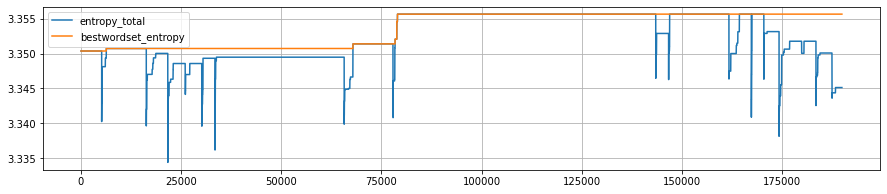

In [24]:
fig, ax = plt.subplots(1, 1, figsize=(15, 3))
#ax.semilogx(wsd.entropy_total)
ax.plot(wsd.entropy_total[10000:], label='entropy_total')
ax.plot(wsd.bestwordset_entropy[10000:], label='bestwordset_entropy')
ax.legend()
ax.grid();

In [25]:
print(wsd.bestwordset_entropy[-1])
wsd.bestwordset

3.355656588786564


[[бубен, разум, полюс, гомон, фокус, тезис, годик, буфер, форум, топот],
 [вымыл, резал, выпек, ведал, вынул],
 [сизый, мятый, некий, пегий, дедов]]

In [29]:
counts, counts2 = wsd.get_counts(wsd.bestwordset)
print(counts)
print(counts2)

[7 7 6 6 8 6 5 4 5 4 3 4 3 4 4 4 4 4 4 4 4]
[5 5 0 0 7 3 2 2 6 6 1 3 4 3 4 3 2 3 2 2 3 2 3 3 3 3 1 1 1 1 1 1 1 2 1 2 1
 1 1 1 4]


In [30]:
def generate_phrase(wordset):
    noun_index = np.random.choice(np.arange(len(wordset[0])), size=2, replace=False)
    verb_index = np.random.choice(np.arange(len(wordset[1])), size=1, replace=False)
    adj_index = np.random.choice(np.arange(len(wordset[2])), size=1, replace=False)
    
    a = ' '.join([wordset[2][adj_index[0]].word, wordset[0][noun_index[0]].word])
    b = wordset[1][verb_index[0]].word
    c = wordset[0][noun_index[1]].word
    
    if np.random.rand(1) > 0.5:
        phrase = a + ' ' + b + ' ' + c
    else:
        phrase = c + ' ' + b + ' ' + a
    return phrase

In [34]:
phrase = generate_phrase(wsd.wordset)
print(phrase)

пятый полюс вымыл газик
